In [1]:
import torchvision
import torch
import PIL.Image
import matplotlib.pyplot as plt
import pandas
import pytorch_lightning as L
from pathlib import Path
from torchvision.transforms import v2
from torch.utils import data
from matplotlib.patches import Rectangle

In [ ]:
def multibox_prior(data, sizes, ratios):
    in_height, in_width = data.shape[-2:]
    size_tensor = torch.tensor(sizes)
    ratio_tensor = torch.tensor(ratios)

    height_step = 1.0 / in_height
    width_step = 1.0 / in_width
    print(height_step, width_step)

    offset_height, offset_width = 0.5, 0.5

    center_height = (torch.arange(in_height) + offset_height) * height_step
    center_width = (torch.arange(in_width) + offset_width) * width_step

    y_pos, x_pos = torch.meshgrid(center_height, center_width, indexing='ij')
    x_pos = x_pos.reshape(-1)
    y_pos = y_pos.reshape(-1)

    width_list = torch.cat(
        (size_tensor * torch.sqrt(ratio_tensor[0]), size_tensor[0]*torch.sqrt(ratio_tensor[1:]))) * in_height / in_width
    height_list = torch.cat(
        (size_tensor / torch.sqrt(ratio_tensor[0]), size_tensor[0] / torch.sqrt(ratio_tensor[1:])))

    anchor_manipulations = torch.stack(
        (-width_list, -height_list, width_list, height_list)).T.repeat(in_height*in_width, 1) / 2

    boxes_per_pixel = len(sizes) + len(ratios) - 1

    out_grid = torch.stack([x_pos, y_pos, x_pos, y_pos],
                           dim=1).repeat_interleave(boxes_per_pixel, dim=0)

    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [ ]:
img = v2.ToImage()(PIL.Image.open('images/catdog.jpg'))
height, width = img.shape[1:]
X = img.unsqueeze(0)
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

0.0017825311942959 0.0013736263736263737


torch.Size([1, 2042040, 4])

In [ ]:
boxes = Y.reshape(height, width, 5, 4)
boxes[250, 250, :, :]

tensor([[ 0.0551,  0.0715,  0.6331,  0.8215],
        [ 0.1514,  0.1965,  0.5367,  0.6965],
        [ 0.2478,  0.3215,  0.4404,  0.5715],
        [-0.0646,  0.1814,  0.7528,  0.7117],
        [ 0.1398, -0.0838,  0.5484,  0.9769]])

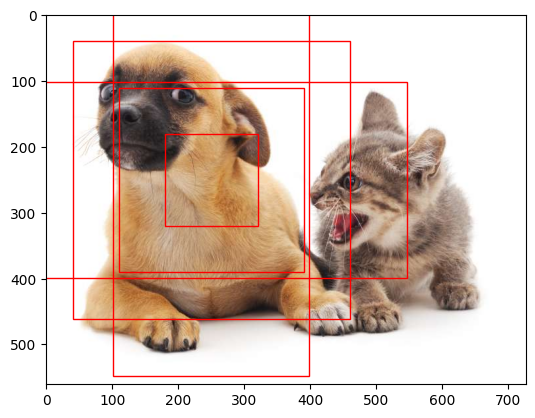

In [ ]:
fig, ax = plt.subplots()
ax.imshow(v2.ToPILImage()(img))
for box in (boxes[250, 250, :, :] * torch.tensor((width, height, width, height))):
    rect = Rectangle((box[0], box[1]), box[2]-box[0], box[3] -
                     box[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)